This notebook trains an image classification model and makes gradual improvements, debugging the model, to improve performance.  **GPUs are encouraged.** In colab, one can add a GPU by clicking the `Runtime` menu and selecting `Change runtime type`. Selecting `GPU` as the hardware accelerator will allow for the usage of a GPU.

Below we download and `unzip` the tiny ImageNet dataset.

Tiny ImageNet is a dataset based on ImageNet with 100,000 images. The dataset consists of 200 categories instead of Imagenet’s full 1,000 categories. Each image is a 64x64 pixel color image, which is about one-twelfth the size of those in Imagenet. Imagenet’s images are 224x224 pixels. There are 500 images in each category instead of Imagenet's roughly 1000 images per category.

In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2020-07-26 13:15:48--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  19.1MB/s    in 16s     

2020-07-26 13:16:05 (14.8 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



We’ll import some code for image processing. We’ll use `keras` for building our algorithm and `numpy` for working with vectors. We’ll also use a function from `sklearn`, the scikit learn library, for splitting up training and testing vectors.

From the 200 categories in the set, we select a list of 36 categories that correspond to animals, `cats_0`. The list includes lions, boa constrictors, and king penguins.

We also select a list of 14 categories from tiny imagenet that correspond to bugs, `cats_1`. The list includes roaches, grasshoppers, scorpions, tarantulas, and dragonflies. 

In [2]:
!pip install keras=='2.3.1'
from PIL import Image
from keras.preprocessing import image
import numpy as np
from sklearn.model_selection import train_test_split
cats_0 = ['n01443537','n01629819','n01641577','n01644900','n01698640','n01742172',
          'n01855672','n01882714','n02002724','n02056570','n02058221','n02074367',
          'n02085620','n02094433','n02099601','n02099712','n02106662','n02113799',
          'n02123045','n02123394','n02124075','n02125311','n02129165','n02132136',
          'n02364673','n02395406','n02403003','n02410509','n02415577','n02423022',
          'n02437312','n02480495','n02481823','n02486410','n02504458','n02509815']
cats_1 = ['n01770393','n01774384','n01774750','n01784675','n02165456','n02190166',
          'n02206856','n02226429','n02231487','n02233338','n02236044','n02268443',
          'n02279972','n02281406']

Using TensorFlow backend.


The `read_cats` subroutine reads the images for the categories `cats` it is given and it associates their vectors with the label `lab`. Initially, the lists of vectors, `vecs`, and labels, `labs`, are empty. We also pass in the desired training and testing set sizes, `train_size` and `test_size`.



We loop through each category, `c`, and image, `i`. For each category and image pair, we construct a filename into the “tiny” dataset. Specifically, the directory that stores the images is called “tiny-imagenet-200/tiny”. Then, there’s a subdirectory for each of the tiny imagenet categories, which contains a subdirectory called “images”. Within that directory, there’s 500 JPEG files, each named with the tiny imagenet category and a number.

We retrieve the image and store it in “img”.
From the image object, we extract an array and flatten it out into a vector. Then, we reshape it to 64x64 x 3 colors.
We string together all the collected images and labels into lists, one list called “vecs”, the other called “labs”.
Once the lists are constructed, we turn the list of vectors into a numpy array.
We split up this array and the labels with the desired train/test sizes and return the result.

In [3]:
def read_cats(cats, lab, train_size, test_size):
  vecs = []
  labs = []
  for c in cats:
    for i in range(500):
      img = image.load_img("tiny-imagenet-200/train/"+c+"/images/"+c+"_"+str(i)+".JPEG")
      img_arr = image.img_to_array(img)
      img_arr = img_arr.flatten()
      img_arr = img_arr.reshape(64,64,3)
      vecs += [img_arr]
      labs += [lab]
  vecs = np.asarray(vecs)
  return(train_test_split(vecs,labs, train_size=train_size,test_size=test_size))

For both `cats_1` and `cats_0`, we use 10 percent of the available data for training and 20 percent for testing. Combining the data from each category will give us our training data, `X_train` and `y_train`, and our test data, `X_test` and `y_test`.

In [4]:
X0_train, X0_test, y0_train, y0_test = read_cats(cats_0, 0, .1, .2)
X1_train, X1_test, y1_train, y1_test = read_cats(cats_1, 1, .1, .2)
X_train = np.concatenate((X0_train, X1_train))
X_test = np.concatenate((X0_test, X1_test))
y_train = np.concatenate((y0_train, y1_train))
y_test = np.concatenate((y0_test, y1_test))

`build_network` builds a VGG-16 model. It consists of a series of 14 convolutional layers, `Conv2D`, interspersed with max pooling layers, `MaxPooling2D`. After these layers, it includes 3 fully connected, `Dense`, layers ending with the output layer.

In the code to build and return the untrained neural network, the main change is in the very first layer and the very last layer. VGG-16 is designed to recognize imagenet images of size 224x224. The “tiny” images in this set are only 64x64. So `input_shape` is different.

The output shape is also different. In the Imagenet challenge, the learners have to pick out an image from 1000 categories. Here, we only have two --- animal and bug. So, we use a single output unit with `sigmoid` activation. A sigmoid unit is one that outputs a number near 1 if the input sums to a positive number and near zero if the input sums to a negative number, with a smooth transition between them around zero. Thus, the outputs look like probabilities. It is trained to produce a number close to 1 for bugs and close to 0 for animals.

In [5]:
def build_network():
  import keras
  from keras.models import Sequential
  from keras.layers import Dense, Activation, Dropout, Flatten
  from keras.layers import Conv2D
  from keras.layers import MaxPooling2D
  input_shape = (64, 64, 3)
  #Instantiate an empty model
  model = Sequential()
  model.add(Conv2D(64, (3, 3), input_shape=input_shape, padding='same', activation='relu'))
  model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dense(4096, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  return(model)

Below we build our network and compile it, adding our `mean_squared_error` `loss` and our `adam` `optimizer`.  We also collect `accuracy` `metrics` as we train. 

In [6]:
model = build_network()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

We call `fit` on our model to train the model below.  The `loss` and `accuracy` for both the training and test data is printed.

In [7]:
model.fit(X_train,y_train, validation_data=(X_test,y_test))

Train on 2500 samples, validate on 5000 samples
Epoch 1/1
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2783 - accuracy: 0.7200 - val_loss: 0.2800 - val_accuracy: 0.7200


One important debugging tool is to look at the data.

Below is an random image and its label from the test set.

1


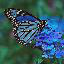

In [8]:
import random
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
i = random.randint(0,len(y_test)-1)

print(y_test[i])
img_arr = X_test[i]
img_arr = preprocess_input(img_arr)
img = image.array_to_img(img_arr)
img

We now rerun the model by balancing the number of examples from `cats_1` and `cats_0`.  We include 500 examples of each category in the training set and the tets set.

We retrain the model and report the new accuracy on the train and test set.

In [9]:
# running again with balanced examples
X0_train, X0_test, y0_train, y0_test = read_cats(cats_0, 0, 500, 500)
X1_train, X1_test, y1_train, y1_test = read_cats(cats_1, 1, 500, 500)
X_train = np.concatenate((X0_train, X1_train))
X_test = np.concatenate((X0_test, X1_test))
y_train = np.concatenate((y0_train, y1_train))
y_test = np.concatenate((y0_test, y1_test))

model = build_network()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train, validation_data=(X_test,y_test))

Train on 1000 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4948 - accuracy: 0.5000 - val_loss: 0.5000 - val_accuracy: 0.5000


Here, we decrease the size of the training set, reducing it to 5 for each category. The neural network model has almost 40 million weights. With only 10 training examples, we should expect MASSIVE overfitting. That is, the learner should easily memorize the training data and obtain zero loss, but we cannot expect it to generalize usefully to new examples. We print the performance of the model on the training and test set using `evaluate`.  However, the performance on this small dataset has low accuracy on the training set. 

In [10]:
# running again with very small training set
X0_train, X0_test, y0_train, y0_test = read_cats(cats_0, 0, 5, 500)
X1_train, X1_test, y1_train, y1_test = read_cats(cats_1, 1, 5, 500)
X_train = np.concatenate((X0_train, X1_train))
X_test = np.concatenate((X0_test, X1_test))
y_train = np.concatenate((y0_train, y1_train))
y_test = np.concatenate((y0_test, y1_test))

model = build_network()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train, validation_data=(X_test,y_test))

print(model.evaluate(X_test,y_test))
print(model.evaluate(X_train,y_train))

Train on 10 samples, validate on 1000 samples
Epoch 1/1
1000/1000 [==============================] - 0s 339us/step
[0.5, 0.5]
10/10 [==============================] - 0s 678us/step
[0.5, 0.5]


Here we increase the number of epochs from 1 to 1000 in an attempt to improve training set accuracy.

In [11]:
# running longer

model = build_network()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train,epochs=1000,verbose=False)

print(model.evaluate(X_test,y_test))
print(model.evaluate(X_train,y_train))

1000/1000 [==============================] - 0s 381us/step
[0.5, 0.5]
10/10 [==============================] - 0s 665us/step
[0.5, 0.5]


We inpsect the weights to make sure the weights haven’t gotten too big. Weight updates are proportional to the size of the gradient, an exploding gradient will manifest as extremely large weights in the network. Running `get_weights` on the learned model will print all the weights. Flipping through, the weights seem to be in a reasonable range. 

Vanishing gradients are a lot harder to spot. They manifest as no weight change at all, especially in the layers closest to the input.

In [12]:
model.get_weights()

[array([[[[ 0.00309325, -0.0497908 , -0.05819392, ..., -0.0800596 ,
           -0.04722577,  0.04468596],
          [-0.06987703,  0.01119967, -0.05955611, ..., -0.08814825,
            0.06788746, -0.07451236],
          [ 0.06426371,  0.01636061,  0.04514264, ...,  0.02047805,
           -0.07898623, -0.07676245]],
 
         [[-0.00867594, -0.08879147, -0.09489784, ..., -0.04473942,
            0.08061639,  0.02587012],
          [ 0.0559782 ,  0.02706664, -0.0273003 , ..., -0.10417344,
            0.04410103,  0.00110877],
          [-0.07250708,  0.01330209,  0.03661027, ..., -0.09670858,
           -0.08109863, -0.0594181 ]],
 
         [[-0.03144711, -0.02735748,  0.02430159, ...,  0.0713688 ,
            0.08824043,  0.01952042],
          [ 0.06315105,  0.0938195 ,  0.01523966, ..., -0.01833817,
            0.0354364 , -0.04070034],
          [-0.01072612,  0.06583431, -0.09292553, ...,  0.09133769,
           -0.06898191,  0.02218914]]],
 
 
        [[[ 0.08709411, -0.0496450

We modify `read_cats` to pre-process the inputs.

Normalizing or pre-processing our instances so they are in a range of values likely to pass through the network well. Keras includes a library has a `preprocess_input` function to prepare the data for learning in our VGG16 model. After calling image array is then flattened and then reshaped into a 64x64 pixel array with 3 color channels representing red, blue, and green.

Activation functions are most reactive to  their inputs when those inputs are in the minus 1 to plus 1 range. So, since pixel values are 0 to 255, we’ll rescale by dividing by 128 and subtracting 1. That makes the smallest value 0 divided by 128 minus 1, or negative 1. The largest value because 256 divided by 128 minus 1, or roughly positive 1.

In [13]:
# Redefine read_cats to preprocess inputs
def read_cats(cats, lab, train_size, test_size):
  vecs = []
  labs = []
  for c in cats:
    for i in range(500):
      img = image.load_img("tiny-imagenet-200/train/"+c+"/images/"+c+"_"+str(i)+".JPEG")
      img_arr = image.img_to_array(img)
      img_arr = preprocess_input(img_arr)
      img_arr = img_arr.flatten()
      img_arr = img_arr / 128. - 1
      img_arr = img_arr.reshape(64,64,3)
      vecs += [img_arr]
      labs += [lab]
  vecs = np.asarray(vecs)
  return(train_test_split(vecs,labs, train_size=train_size,test_size=test_size))

We now retrain our model with on our small sample of 10 training examples and inspect our accuracy for both the train and test sets.

In [14]:
# running again with preprocessing applied
X0_train, X0_test, y0_train, y0_test = read_cats(cats_0, 0, 5, 500)
X1_train, X1_test, y1_train, y1_test = read_cats(cats_1, 1, 5, 500)
X_train = np.concatenate((X0_train, X1_train))
X_test = np.concatenate((X0_test, X1_test))
y_train = np.concatenate((y0_train, y1_train))
y_test = np.concatenate((y0_test, y1_test))

model = build_network()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train,epochs=1000,verbose=False)
print(model.evaluate(X_test,y_test))
print(model.evaluate(X_train,y_train))

1000/1000 [==============================] - 0s 384us/step
[0.5, 0.5]
10/10 [==============================] - 0s 707us/step
[0.5, 0.5]


We take a look at the training data and see that all of the examples with the label zero precede all the examples with the label one. 

Many neural network solvers process their training instances in order, which can lead to bias in the way that they make their weight updates. 


In [15]:
y_train

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

We reshuffle the training data to try to improve the performance of the model.

In [16]:
X0_train, X0_test, y0_train, y0_test = read_cats(cats_0, 0, 5, 500)
X1_train, X1_test, y1_train, y1_test = read_cats(cats_1, 1, 5, 500)
X_train = np.concatenate((X0_train, X1_train))
X_test = np.concatenate((X0_test, X1_test))
y_train = np.concatenate((y0_train, y1_train))
y_test = np.concatenate((y0_test, y1_test))
# Reshuffle training data
X_first, X_second, y_first, y_second = train_test_split(X_train,y_train,train_size=0.5)
X_train = np.concatenate((X_first, X_second))
y_train = np.concatenate((y_first, y_second))

Below we train the model on the reshuffled and preprocessed data and report the accuracy on the train and test set.

In [17]:
model = build_network()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(X_train,y_train,epochs=1000,verbose=False)

# print(model.evaluate(X_test,y_test))
print(model.evaluate(X_train,y_train))

10/10 [==============================] - 0s 5ms/step
[0.5, 0.5]


Here, we retrain the model using `SGD` as the optimizer instead of `adam` and increase the learning rate to `lr=0.05`.

We report the accuracy and loss of the training data.

In [18]:
# try another solver with a bigger learning rate
from keras import optimizers

solver = optimizers.SGD(lr=0.05)

model = build_network()
model.compile(loss='mean_squared_error', optimizer=solver, metrics=['accuracy'])
model.fit(X_train,y_train)

print(model.evaluate(X_train,y_train))

Epoch 1/1
10/10 [==============================] - 0s 4ms/step
[0.24992379546165466, 0.5]


Below is the accuracy and loss on the test set.

In [19]:
print(model.evaluate(X_test,y_test))

1000/1000 [==============================] - 0s 354us/step
[0.24999765455722808, 0.49799999594688416]


Here, we increase the size of the training data to 100 training examples.

In [20]:
# running again with more training data
X0_train, X0_test, y0_train, y0_test = read_cats(cats_0, 0, 50, 500)
X1_train, X1_test, y1_train, y1_test = read_cats(cats_1, 1, 50, 500)
X_train = np.concatenate((X0_train, X1_train))
X_test = np.concatenate((X0_test, X1_test))
y_train = np.concatenate((y0_train, y1_train))
y_test = np.concatenate((y0_test, y1_test))

Below build our model again using `SGD` and `lr=0.05`

In [21]:
from keras import optimizers

solver = optimizers.SGD(lr=0.05)
model = build_network()
model.compile(loss='mean_squared_error', optimizer=solver, metrics=['accuracy'])

We train our model with our new dataset of 100 training examples.

In [22]:
model.fit(X_train,y_train,epochs=1000,verbose=False)

print(model.evaluate(X_test,y_test))
print(model.evaluate(X_train,y_train))

1000/1000 [==============================] - 0s 382us/step
[0.33803662824630737, 0.6370000243186951]
100/100 [==============================] - 0s 377us/step
[0.010004644368022184, 0.9900000095367432]


Now we dramatically increase the size of the training set to 10,000 examples, 5,000 of each class.

In [23]:
# running again with maximum training data
X0_train, X0_test, y0_train, y0_test = read_cats(cats_0, 0, 5000, 500)
X1_train, X1_test, y1_train, y1_test = read_cats(cats_1, 1, 5000, 500)
X_train = np.concatenate((X0_train, X1_train))
X_test = np.concatenate((X0_test, X1_test))
y_train = np.concatenate((y0_train, y1_train))
y_test = np.concatenate((y0_test, y1_test))

We build and compile our model again using `SGD`.

In [24]:
from keras import optimizers

solver = optimizers.SGD(lr=0.05)
model = build_network()
model.compile(loss='mean_squared_error', optimizer=solver, metrics=['accuracy'])

Here we train the model for 100 `epochs`.

In [25]:
model.fit(X_train,y_train,epochs=100)

print(model.evaluate(X_test,y_test))
print(model.evaluate(X_train,y_train))

Epoch 1/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2499 - accuracy: 0.5075
Epoch 2/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2492 - accuracy: 0.5310
Epoch 3/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2467 - accuracy: 0.5677
Epoch 4/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2334 - accuracy: 0.6122
Epoch 5/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1974 - accuracy: 0.7044
Epoch 6/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1807 - accuracy: 0.7390
Epoch 7/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1733 - accuracy: 0.7503
Epoch 8/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1694 - accuracy: 0.7567
Epoch 9/100
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1646 - accuracy: 0.7577
Epoch 10/100
10000/10000 [====================